07391449,

08436710

In [1]:
import numpy as np
import keras
import cv2
import pandas as pd
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import InputLayer
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import itertools
import matplotlib.pyplot as plt
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
file_path = "D:\Admin\Documents\Year_4\AMLS\Assessment\dataset_AMLS_20-21\cartoon_set\img"
labels_path = "D:\Admin\Documents\Year_4\AMLS\Assessment\dataset_AMLS_20-21\cartoon_set\labels.csv"

In [3]:
df = pd.read_csv(labels_path)
sample_size = 1000
df = df.drop(columns="Unnamed: 0")

temp = df["file_name"]
df.insert(loc=0, column="file_names", value=temp)
df = df.drop(columns="file_name")

df["eye_color"] = df["eye_color"].replace(to_replace=[0], value=["Brown"])
df["eye_color"] = df["eye_color"].replace(to_replace=[1], value=["Blue"])
df["eye_color"] = df["eye_color"].replace(to_replace=[2], value=["Green"])
df["eye_color"] = df["eye_color"].replace(to_replace=[3], value=["Hazel"])
df["eye_color"] = df["eye_color"].replace(to_replace=[4], value=["Black"])

one_hot = pd.get_dummies(df["eye_color"])
df = df.drop(columns="eye_color")
df = df.join(one_hot)

df = df.drop(df.index[sample_size:])

In [27]:
train, validation, test = \
              np.split(df.sample(frac=1), 
                       [int(.6*len(df)), int(.8*len(df))])

In [28]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

In [29]:
img_path = os.path.join(file_path, train["file_names"].iloc[0])
img = cv2.imread(img_path)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray)
rx = 0
ry = 0
rw = 0
rh = 0
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        roi = roi_color[ey:ey+eh, ex: ex+ew]
rx = ex
ry = ey
rw = ew
rh = eh

In [30]:
cv2.imshow("bruh",roi)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [31]:
print(rx, ry, rw, ry)

115 47 60 47


In [32]:
def create_eye_matrix(file_path, df, face, eye, rx, ry, rw, rh):
    eyes = []
    labels = []
    for file_name in df["file_names"]:
        img_path = os.path.join(file_path, file_name)
        img = cv2.imread(img_path)
        crop = img[ry:ry+rh, rx:rx+rw]
#         hsi_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
#         temp = crop.mean(axis=0)
#         avg_col = temp.mean(axis=0)[0]
        if crop is not None:
            eyes.append(crop)
            temp = file_name.split(".")[0]
            temp1 = np.array(df.loc[int(temp)])
            labels.append(temp1[2:])
    return eyes, labels

In [33]:
train_eyes, train_labels = create_eye_matrix(file_path, train, face_cascade, eye_cascade, rx, ry, rw, rh)

In [34]:
val_eyes, val_labels = create_eye_matrix(file_path, validation, face_cascade, eye_cascade, rx, ry, rw, rh)

In [35]:
test_eyes, test_labels = create_eye_matrix(file_path, test, face_cascade, eye_cascade, rw, ry, rw, rh)

In [36]:
train_eyes = (np.array(train_eyes)).astype(int)
val_eyes = (np.array(val_eyes)).astype(int)
test_eyes = (np.array(test_eyes)).astype(int)

In [37]:
datagen = ImageDataGenerator()

train_generator = datagen.flow(x = train_eyes, y = train_labels)

validation_generator = datagen.flow(x = val_eyes, y = val_labels)

test_generator = datagen.flow(x = test_eyes, y = test_labels)

In [50]:
model = Sequential()
model.add(InputLayer(input_shape=train_eyes[0].shape))
model.add(Conv2D(filters=96, kernel_size=(2,2), strides=4, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(5, activation="softmax"))

In [56]:
model = Sequential()
model.add(InputLayer(input_shape=train_eyes[0].shape))
model.add(Conv2D(filters=100, kernel_size=(3,3), strides=2, activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Conv2D(filters=200, kernel_size=(2,2), strides=2, activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Conv2D(filters=400,kernel_size=(2,2),activation="relu"))
model.add(Flatten())
model.add(Dense(1024))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Dropout(0.2))
model.add(Dense(5, activation="softmax"))

In [57]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 29, 29, 100)       2800      
_________________________________________________________________
batch_normalization_5 (Batch (None, 29, 29, 100)       400       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 100)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 200)         80200     
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 200)         800       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 200)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 400)        

In [58]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
train_steps = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

In [60]:
history = model.fit(x=train_generator, 
          steps_per_epoch=train_steps,
          validation_data=validation_generator,
          validation_steps=validation_steps,
          epochs=25)

Epoch 1/25
18/18 [==============================] - 3s 152ms/step - loss: 0.6249 - accuracy: 0.7937 - val_loss: 1.3861 - val_accuracy: 0.6854
Epoch 2/25
18/18 [==============================] - 2s 128ms/step - loss: 0.5934 - accuracy: 0.7958 - val_loss: 3.9085 - val_accuracy: 0.6786
Epoch 3/25
18/18 [==============================] - 2s 122ms/step - loss: 0.6050 - accuracy: 0.7982 - val_loss: 4.8987 - val_accuracy: 0.6833
Epoch 4/25
18/18 [==============================] - 2s 128ms/step - loss: 0.5721 - accuracy: 0.7993 - val_loss: 3.5862 - val_accuracy: 0.7000
Epoch 5/25
18/18 [==============================] - 2s 128ms/step - loss: 0.5777 - accuracy: 0.8003 - val_loss: 4.0265 - val_accuracy: 0.6714
Epoch 6/25
18/18 [==============================] - 2s 124ms/step - loss: 0.6008 - accuracy: 0.7979 - val_loss: 2.7269 - val_accuracy: 0.6905
Epoch 7/25
18/18 [==============================] - 2s 124ms/step - loss: 0.5916 - accuracy: 0.8000 - val_loss: 1.0049 - val_accuracy: 0.6881
Epoch 

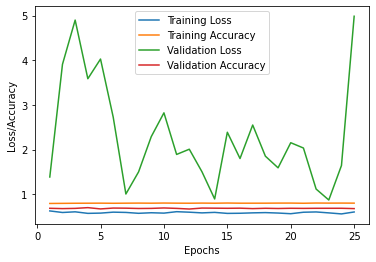

In [61]:
epochs = range(1, len(history.epoch) + 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()